# Chapter 5: Finite Difference Time Domain (FDTD) Method

Finite Difference Time Domain (FDTD) is the most popular method simulating wave propagation in domain setups where the propagation domain is small enough to approximate a wavelength. As such it is very popular for microwave (radio-frequency and optical) simulations. Within the field of Computational Electromagnetics, the method proves essential for the simulation and modelling of antennas, waveguides and other microwave devices as well as nano-scale optical devices (integrated photonics).

The method is computationally efficient once:
- it requires low memory usage once only the current and previous time steps are stored at each step
- it implements explicit time-stepping, reducing the number of system of equations to solve in each time step.

The method is also possible to be used in a wide range of geometries as long as the discretized grid is not too coarse so that the maixmum spatial step is higher than corresponding spatial step of the wave's group velocity. This will be futher explained when analysing the stability of the method. Another issue with this method is that because it is based on Finite Differences, it produces an increased numerical error for geometries that are:
- curved
- present sharp edges
- are oblique to the grid cell's axes.

This is known as the "Staircase" approximation error and has been the subject of many research papers.

The Finite Element Method in the time-domain (FEM-TD) is much more suited in both cases where FDTD presents high numerical dispersion:
1. When either the spatial extension or temporal duration of the simulation is much larger than Courant's stability condition allows regarding the wave's group velocity
2. When the geometry is complex and the grid is not fine enough to resolve the geometry.

An example problem in which FDTD is not suitable is the simulation of eddy currents in the ferromagnetic core of electric rotor's transformer.

In this chapter, to solve the second issue we will explore an adaptive grid refinement algorithm that will refine the grid in regions where the wave is not well resolved.

## Solving the 1D wave equation using FDTD

Let us revisit the wave equation:

$$ \frac{\partial^2 \bf{E}}{\partial t^2} = c^2 \nabla \cdot \bf{E} $$

where $E(\vec{r},t)$ is the electric field wave function, $c$ is the wave speed, $x$ is the spatial coordinate and $t$ is the time coordinate.

Considering now a 1D domain, the wave equation becomes:

$$ \frac{\partial^2 E(x,t)}{\partial t^2} = c^2 \frac{\partial^2 E(x,t)}{\partial x^2} $$

Discretizing the differential equation's domain using 2nd-order Finite Differences on staggered-grid domain, we obtain:

$$ \frac{E(x,t+\Delta t) - 2E(x,t) + E(x,t-\Delta t)}{(\Delta t)^2} = c^2 \frac{E(x+\Delta x,t) - 2E(x,t) + E(x-\Delta x,t)}{(\Delta x)^2} \rightarrow$$
$$ \rightarrow \frac{E(r\Delta x,(n+1)\Delta t) - 2E(r\Delta x,n\Delta t) + E(r\Delta x,(n-1)\Delta t)}{(\Delta t)^2} = $$ 
$$ = c^2 \frac{E((r+1)\Delta x,n\Delta t) - 2E(r\Delta x,n\Delta t) + E((r-1)\Delta x,n\Delta t)}{(\Delta x)^2} $$

where $\Delta t$ is the time step and $\Delta x$ is the spatial step. This equation can be more compactly describbed using subscripts and underscript notation:

$$ E\big|^{n+1}_{r} = 2E\big|^{n}_{r} - E\big|^{n-1}_{r} + \left(\frac{c\Delta t}{\Delta x}\right)^2 (E\big|^{n}_{r+1} - 2E\big|^{n}_{r} + E\big|^{n}_{r-1}) $$

where $r$ is the spatial index and $n$ is the time index. Notice that the equation is similar to <a href=/Users/dasdias/Documents/PhDCourseWork/computational-electromagnetics/computational_electromagnetics/ch3_finite_diff.ipynb>Chapter 5 (Finite Differences Method)</a> [Gauss-Sidel Iteration Method with Relaxation factor](chapter3:gauss-sidel). In this case the relaxation factor is defined as 

$$ R = \left(\frac{c\Delta t}{\Delta x}\right)^2 $$

and as it can be seen, it has a direct impact on the stability of the numerical method.

### 1D FDTD algorithm: Square Wave propagation example

Let us consider a 1D domain were a square electric pulse is propagating. The domain is defined by $x \in [0,1]$. Let us play around with the temporal and spatial step sizes and see how the resulting popagated wave solution.

The previous equation can be implemented in matrix form as follows:

$$ E\big|^{n-1}_r - R \cdot E\big|^{n}_{r-1} - 2 (1 - R)\cdot E\big|^{n}_r -R\cdot E\big|^{n}_{r+1} + E\big|^{n+1}_r = 0 \rightarrow $$

$$ \rightarrow 0\cdot E\big|^{n-1}_{r-1} + 1\cdot E\big|^{n-1}_r + 0\cdot E\big|^{n-1}_{r+1} - R \cdot E\big|^{n}_{r-1} - 2 (1 - R)\cdot E\big|^{n}_r -R\cdot E\big|^{n}_{r+1} + 0\cdot E\big|^{n+1}_{r-1} + 1\cdot E\big|^{n+1}_r + 0\cdot E\big|^{n+1}_{r+1} = 0 \rightarrow $$

$$ \rightarrow \bf{I} \cdot \begin{bmatrix} E\big|_{0} \\ E\big|_{1} \\ \vdots \\ E\big|_{r} \end{bmatrix}^{n-1} - \begin{bmatrix} 2(1-R) & R & 0 & \dots & 0 \\ R & 2(1-R) & R & \dots & 0 \\ \vdots &  & \ddots &  & \vdots  \\ 0 & \dots & R & 2(1-R) & R \\ 0 & \dots & 0 & R & 2(1-R) \end{bmatrix} \cdot \begin{bmatrix} E\big|_{0} \\ E\big|_{1} \\ \vdots \\ E\big|_{r} \end{bmatrix}^{n} + \bf{I} \cdot \begin{bmatrix} E\big|_{0} \\ E\big|_{1} \\ \vdots \\ E\big|_{r} \end{bmatrix}^{n+1} = 0  $$


In [1]:
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 1.0, 'Space-time grid for 1D wave equation')

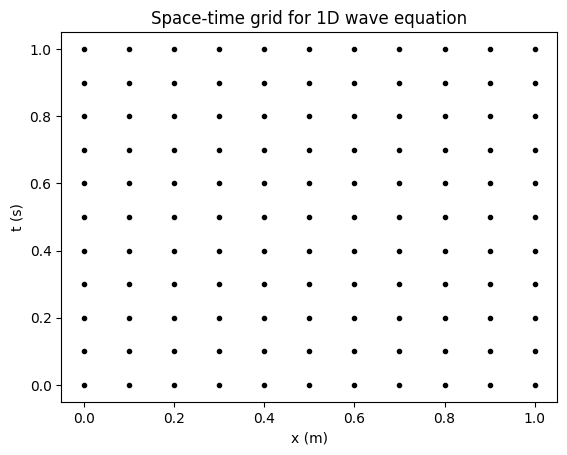

In [10]:
# define space and time grid

t_Np = 11
x_Np = 11

t = np.linspace(0, 1, t_Np)
x = np.linspace(0, 1, x_Np)

tt, xx = np.meshgrid(t, x)

fig, ax = plt.subplots()
ax.plot(tt, xx, '.k')
ax.set_xlabel('x (m)')
ax.set_ylabel('t (s)')
ax.set_title('Space-time grid for 1D wave equation')

Text(0.5, 1.0, 'Initial condition for the wave equation')

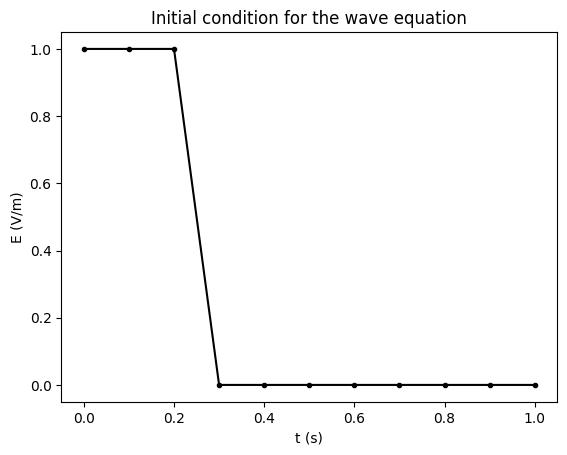

In [15]:
# Define the initial condition for the wave equation by using a pulse function
E0 = np.zeros(t_Np)
pd = 0.1 # pulse duration
E0[np.logical_and(t >= 0.0, t <= 0.1 + pd)] = 1

fig, ax = plt.subplots()
ax.plot(t, E0, '.-k')
ax.set_xlabel('t (s)')
ax.set_ylabel('E (V/m)')
ax.set_title('Initial condition for the wave equation')

In [ ]:
# Define the wave equation in matrix form

c = 1.0 # speed of light
dx = (x[-1] - x[0]) / x_Np # spatial step
dt = (t[-1] - t[0]) / t_Np # temporal step

# Define the matrix A
A = np.zeros((t_Np, x_Np))
